Cell 1 — Imports + config

In [7]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

np.random.seed(42)  # reproducible (walau analisis deterministic)

# =========================
# PATHS (sesuaikan)
# =========================
BASE_HEAD2_DIR = Path(r"E:\0.TA_Teguh\GMM Trial 2\Head 2")  # Head 2 output (per subject folder, per trial file)
SUBJECTS = list("ABCDEFGHIJ")

# =========================
# TRIAL-2 params (untuk valid fallback)
# =========================
MIN_POINTS = 5   

print("BASE_HEAD2_DIR:", BASE_HEAD2_DIR)
print("SUBJECTS      :", SUBJECTS)
print("MIN_POINTS    :", MIN_POINTS)


BASE_HEAD2_DIR: E:\0.TA_Teguh\GMM Trial 2\Head 2
SUBJECTS      : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
MIN_POINTS    : 5


Cell 2 — Utility: list files Head-2 per subject

In [8]:
def list_head2_files(subject: str):
    """
    List all Head-2 CSV files for a subject.
    Expected pattern: BASE_HEAD2_DIR/<subject>/Jalan*.csv
    """
    subj_dir = BASE_HEAD2_DIR / subject
    pattern = str(subj_dir / "Jalan*.csv")
    files = sorted(glob.glob(pattern))
    return files

# quick sanity check
for s in SUBJECTS:
    files = list_head2_files(s)
    print(f"{s}: {len(files)} files, example: {files[0] if files else 'NONE'}")


A: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\A\Jalan1.csv
B: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\B\Jalan1.csv
C: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\C\Jalan1.csv
D: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\D\Jalan1.csv
E: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\E\Jalan1.csv
F: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\F\Jalan1.csv
G: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\G\Jalan1.csv
H: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\H\Jalan1.csv
I: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\I\Jalan1.csv
J: 72 files, example: E:\0.TA_Teguh\GMM Trial 2\Head 2\J\Jalan1.csv


Cell 3 — Load Head-2 into one DataFrame (frame-level), with dedup + schema normalization

In [9]:
def _pick_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def load_all_head2(subjects=SUBJECTS):
    rows = []
    dup_reports = []

    for subj in subjects:
        files = list_head2_files(subj)
        if not files:
            print(f"[WARN] No Head-2 files for subject {subj}")
            continue

        for fpath in files:
            fpath = Path(fpath)
            trial_name = fpath.stem  # "Jalan12"
            try:
                df = pd.read_csv(fpath)
            except Exception as e:
                print(f"[ERROR] Failed reading {fpath}: {e}")
                continue

            # ---- required columns (try to be robust)
            col_frame = _pick_col(df, ["frame", "Frame", "frame_id"])
            col_nroi  = _pick_col(df, ["N_roi", "n_roi", "N_ROI", "nroi"])
            col_valid = _pick_col(df, ["valid_minpts", "valid", "is_valid"])
            col_nin   = _pick_col(df, ["N_inlier", "n_inlier", "N_INLIER", "ninlier", "nInlier"])
            col_conf  = _pick_col(df, ["conf", "confidence", "conf_frame"])

            if col_frame is None:
                print(f"[WARN] Missing 'frame' in {fpath.name}, skip")
                continue

            # build normalized frame-level table
            out = pd.DataFrame()
            out["subject"] = subj
            out["trial"]   = trial_name
            out["frame"]   = pd.to_numeric(df[col_frame], errors="coerce").astype("Int64")

            # optional numeric columns
            if col_nroi is not None:
                out["N_roi"] = pd.to_numeric(df[col_nroi], errors="coerce")
            else:
                out["N_roi"] = np.nan

            if col_nin is not None:
                out["N_inlier"] = pd.to_numeric(df[col_nin], errors="coerce")
            else:
                # if not found, we can't do N_target analysis properly
                out["N_inlier"] = np.nan

            if col_conf is not None:
                out["conf"] = pd.to_numeric(df[col_conf], errors="coerce")
            else:
                out["conf"] = np.nan

            # validity: prefer explicit valid_minpts, otherwise fallback using N_roi >= MIN_POINTS
            if col_valid is not None:
                v = pd.to_numeric(df[col_valid], errors="coerce")
                out["valid_minpts"] = (v.fillna(0).astype(int) > 0).astype(int)
            else:
                out["valid_minpts"] = ((out["N_roi"].fillna(0) >= MIN_POINTS)).astype(int)

            rows.append(out)

    if not rows:
        return pd.DataFrame(), pd.DataFrame()

    all_df = pd.concat(rows, ignore_index=True)

    # drop rows with missing frame
    all_df = all_df.dropna(subset=["frame"]).copy()
    all_df["frame"] = all_df["frame"].astype(int)

    # ---- DUPLICATE CHECK: (subject, trial, frame) must be unique
    key = ["subject", "trial", "frame"]
    dup_mask = all_df.duplicated(key, keep=False)
    if dup_mask.any():
        dups = all_df.loc[dup_mask, key].value_counts().reset_index(name="count")
        dup_reports = dups.sort_values("count", ascending=False)
        print(f"[WARN] Found duplicates for (subject, trial, frame): {len(dup_reports)} keys duplicated")
        # keep last occurrence
        all_df = all_df.sort_values(key).drop_duplicates(key, keep="last").reset_index(drop=True)
        print("[INFO] Duplicates dropped (keep='last').")

    dup_reports_df = pd.DataFrame(dup_reports) if isinstance(dup_reports, list) else dup_reports
    return all_df, dup_reports_df

df_h2, df_dups = load_all_head2(SUBJECTS)

print("df_h2 shape:", df_h2.shape)
df_h2.head()


[WARN] Found duplicates for (subject, trial, frame): 0 keys duplicated
[INFO] Duplicates dropped (keep='last').
df_h2 shape: (696, 7)


,subject,trial,frame,N_roi,N_inlier,conf,valid_minpts
0,NaN,NaN,1,0,0,0.0,0
1,NaN,NaN,2,1,0,0.0,0
2,NaN,NaN,3,1,0,0.0,0
3,NaN,NaN,4,0,0,0.0,0
4,NaN,NaN,5,5,5,1.0,1


Cell 4 — Sanity checks (missing columns, NaNs, duplicates report)

In [10]:
# duplicates report (if any)
if isinstance(df_dups, pd.DataFrame) and not df_dups.empty:
    display(df_dups.head(20))

# how many NaNs in N_inlier?
nan_nin = df_h2["N_inlier"].isna().sum()
print("NaN N_inlier:", nan_nin, "out of", len(df_h2))

# if too many NaNs, stop (analysis would be meaningless)
if nan_nin > 0:
    print("[WARN] Some rows have NaN N_inlier. Those frames will be excluded from sampling pressure calc.")

# valid/invalid counts
print(df_h2["valid_minpts"].value_counts(dropna=False))


NaN N_inlier: 0 out of 696
valid_minpts
1    623
0     73
Name: count, dtype: int64


Cell 5 — Build point-count dataset for analysis

In [11]:
# Keep only rows where N_inlier is known
df_counts = df_h2.dropna(subset=["N_inlier"]).copy()
df_counts["N_inlier"] = df_counts["N_inlier"].astype(int)

# Two views:
# - ALL frames (including invalid) -> useful to understand how many invalid exist
# - VALID frames only -> the ONLY one that should drive N_target decisions
df_all   = df_counts.copy()
df_valid = df_counts[df_counts["valid_minpts"] == 1].copy()

print("ALL frames used   :", len(df_all))
print("VALID frames used :", len(df_valid))
display(df_valid.head())


ALL frames used   : 696
VALID frames used : 623


,subject,trial,frame,N_roi,N_inlier,conf,valid_minpts
4,NaN,NaN,5,5,5,1.000000,1
11,NaN,NaN,12,9,9,1.000000,1
14,NaN,NaN,15,8,8,1.000000,1
15,NaN,NaN,16,28,27,0.964286,1
16,NaN,NaN,17,6,6,1.000000,1


Cell 6 — Descriptive stats (global + per subject)

In [12]:
def describe_points(arr: np.ndarray):
    arr = np.asarray(arr)
    return {
        "min": float(np.min(arr)),
        "max": float(np.max(arr)),
        "mean": float(np.mean(arr)),
        "median": float(np.median(arr)),
        "p25": float(np.percentile(arr, 25)),
        "p50": float(np.percentile(arr, 50)),
        "p75": float(np.percentile(arr, 75)),
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "p99": float(np.percentile(arr, 99)),
    }

def print_stats(title, arr):
    st = describe_points(arr)
    print(f"\n=== {title} ===")
    for k, v in st.items():
        print(f"  {k:6s}: {v:.3f}")
    return st

# GLOBAL
stats_all = print_stats("GLOBAL (ALL frames)", df_all["N_inlier"].values)
stats_val = print_stats("GLOBAL (VALID frames only)", df_valid["N_inlier"].values)

# PER SUBJECT (VALID only)
print("\n=== PER SUBJECT (VALID frames only) ===")
per_subject_stats = []
for s in SUBJECTS:
    sub = df_valid[df_valid["subject"] == s]
    if len(sub) == 0:
        print(f"Subject {s}: NO VALID data")
        continue
    st = describe_points(sub["N_inlier"].values)
    per_subject_stats.append({"subject": s, **st, "n_frames": len(sub)})
    print(f"\nSubject {s} (VALID): n={len(sub)}")
    for k, v in st.items():
        print(f"  {k:6s}: {v:.3f}")

df_per_subject_stats = pd.DataFrame(per_subject_stats)
df_per_subject_stats.head()



=== GLOBAL (ALL frames) ===
  min   : 0.000
  max   : 150.000
  mean  : 44.527
  median: 41.000
  p25   : 11.750
  p50   : 41.000
  p75   : 67.000
  p90   : 91.000
  p95   : 111.000
  p99   : 147.000

=== GLOBAL (VALID frames only) ===
  min   : 5.000
  max   : 150.000
  mean  : 49.745
  median: 46.000
  p25   : 22.000
  p50   : 46.000
  p75   : 70.000
  p90   : 95.000
  p95   : 115.900
  p99   : 147.000

=== PER SUBJECT (VALID frames only) ===
Subject A: NO VALID data
Subject B: NO VALID data
Subject C: NO VALID data
Subject D: NO VALID data
Subject E: NO VALID data
Subject F: NO VALID data
Subject G: NO VALID data
Subject H: NO VALID data
Subject I: NO VALID data
Subject J: NO VALID data


""


Cell 7 — Auto-generate candidate N_target (data-driven)

In [13]:
# Candidate generator around p50/p75/p90 of VALID frames
p50 = int(round(stats_val["p50"]))
p75 = int(round(stats_val["p75"]))
p90 = int(round(stats_val["p90"]))

# Make a small grid around those percentiles
def around(x, steps=( -4, 0, 4 )):
    out = []
    for d in steps:
        v = x + d
        if v > 0:
            out.append(v)
    return out

N_candidates = sorted(set(
    around(p50, (-4, 0, 4)) +
    around(p75, (-4, 0, 4)) +
    around(p90, (-4, 0, 4))
))

print("Auto N_candidates (from VALID p50/p75/p90):", N_candidates)


Auto N_candidates (from VALID p50/p75/p90): [42, 46, 50, 66, 70, 74, 91, 95, 99]


Cell 8 — Simulate sampling pressure for each N_target (VALID only)

In [14]:
def simulate_sampling_pressure(df_valid: pd.DataFrame, n_targets):
    """
    df_valid must already be VALID frames only and have column N_inlier (int).
    For each N_target:
      - fill: frames needing upsampling (N_inlier < N_target)
      - down: frames needing downsampling (N_inlier > N_target)
      - equal
    Also compute deficit/excess statistics for practical "pressure" evaluation.
    """
    records = []
    M = df_valid["N_inlier"].values.astype(int)
    total = len(M)

    for N in n_targets:
        need_fill = M < N
        need_down = M > N
        equal     = M == N

        n_fill = int(need_fill.sum())
        n_down = int(need_down.sum())
        n_eq   = int(equal.sum())

        # deficits/excess
        deficits = (N - M[need_fill]) if n_fill > 0 else np.array([])
        excess   = (M[need_down] - N) if n_down > 0 else np.array([])

        rec = {
            "N_target": int(N),
            "total_frames_used": int(total),
            "n_need_fill": n_fill,
            "n_equal": n_eq,
            "n_need_down": n_down,
            "pct_need_fill": 100.0 * n_fill / total if total else 0.0,
            "pct_equal": 100.0 * n_eq / total if total else 0.0,
            "pct_need_down": 100.0 * n_down / total if total else 0.0,
            "avg_deficit": float(deficits.mean()) if deficits.size else 0.0,
            "p95_deficit": float(np.percentile(deficits, 95)) if deficits.size else 0.0,
            "avg_excess": float(excess.mean()) if excess.size else 0.0,
            "p95_excess": float(np.percentile(excess, 95)) if excess.size else 0.0,
        }
        records.append(rec)

    return pd.DataFrame(records).sort_values("N_target").reset_index(drop=True)

df_pressure = simulate_sampling_pressure(df_valid, N_candidates)
display(df_pressure)


,N_target,total_frames_used,n_need_fill,n_equal,n_need_down,pct_need_fill,pct_equal,pct_need_down,avg_deficit,p95_deficit,avg_excess,p95_excess
0,42,623,277,8,338,44.462279,1.284109,54.253612,22.490975,37.0,32.707101,86.3
1,46,623,304,8,311,48.796148,1.284109,49.919743,24.365132,41.0,31.318328,84.5
2,50,623,330,8,285,52.969502,1.284109,45.746388,26.318182,45.0,29.915789,88.2
3,66,623,436,10,177,69.983949,1.605136,28.410915,34.121560,61.0,26.836158,80.2
4,70,623,464,6,153,74.478331,0.963082,24.558587,35.976293,65.0,26.627451,77.0
5,74,623,492,6,125,78.972713,0.963082,20.064205,37.847561,69.0,28.080000,73.0
6,91,623,549,5,69,88.121990,0.802568,11.075441,50.092896,85.6,26.072464,57.0
7,95,623,559,2,62,89.727127,0.321027,9.951846,53.171735,89.1,24.661290,53.0
8,99,623,567,0,56,91.011236,0.000000,8.988764,56.395062,93.0,23.035714,49.0


Cell 9 — (Optional) Compare pressure on ALL frames vs VALID frames

In [15]:
# WARNING: ALL frames includes invalid, but still uses N_inlier column
# If your invalid frames have N_inlier=0 (or NaN), statistics will shift.
df_all_validlike = df_all.copy()  # could include invalid
df_all_validlike = df_all_validlike.dropna(subset=["N_inlier"])
df_all_validlike["N_inlier"] = df_all_validlike["N_inlier"].astype(int)

# "valid_only=False" effect: pressure may look very different
df_pressure_all = simulate_sampling_pressure(df_all_validlike, N_candidates)

print("=== Pressure (VALID frames only) ===")
display(df_pressure)

print("=== Pressure (ALL frames, incl invalid) ===")
display(df_pressure_all)


=== Pressure (VALID frames only) ===


,N_target,total_frames_used,n_need_fill,n_equal,n_need_down,pct_need_fill,pct_equal,pct_need_down,avg_deficit,p95_deficit,avg_excess,p95_excess
0,42,623,277,8,338,44.462279,1.284109,54.253612,22.490975,37.0,32.707101,86.3
1,46,623,304,8,311,48.796148,1.284109,49.919743,24.365132,41.0,31.318328,84.5
2,50,623,330,8,285,52.969502,1.284109,45.746388,26.318182,45.0,29.915789,88.2
3,66,623,436,10,177,69.983949,1.605136,28.410915,34.121560,61.0,26.836158,80.2
4,70,623,464,6,153,74.478331,0.963082,24.558587,35.976293,65.0,26.627451,77.0
5,74,623,492,6,125,78.972713,0.963082,20.064205,37.847561,69.0,28.080000,73.0
6,91,623,549,5,69,88.121990,0.802568,11.075441,50.092896,85.6,26.072464,57.0
7,95,623,559,2,62,89.727127,0.321027,9.951846,53.171735,89.1,24.661290,53.0
8,99,623,567,0,56,91.011236,0.000000,8.988764,56.395062,93.0,23.035714,49.0


=== Pressure (ALL frames, incl invalid) ===


,N_target,total_frames_used,n_need_fill,n_equal,n_need_down,pct_need_fill,pct_equal,pct_need_down,avg_deficit,p95_deficit,avg_excess,p95_excess
0,42,696,350,8,338,50.287356,1.149425,48.563218,26.560000,42.0,32.707101,86.3
1,46,696,377,8,311,54.166667,1.149425,44.683908,28.554377,46.0,31.318328,84.5
2,50,696,403,8,285,57.902299,1.149425,40.948276,30.607940,50.0,29.915789,88.2
3,66,696,509,10,177,73.132184,1.436782,25.431034,38.693517,66.0,26.836158,80.2
4,70,696,537,6,153,77.155172,0.862069,21.982759,40.601490,70.0,26.627451,77.0
5,74,696,565,6,125,81.178161,0.862069,17.959770,42.518584,74.0,28.080000,73.0
6,91,696,622,5,69,89.367816,0.718391,9.913793,54.893891,91.0,26.072464,57.0
7,95,696,632,2,62,90.804598,0.287356,8.908046,58.003165,95.0,24.661290,53.0
8,99,696,640,0,56,91.954023,0.000000,8.045977,61.254688,99.0,23.035714,49.0


Cell 10 — Quick plots (histogram)

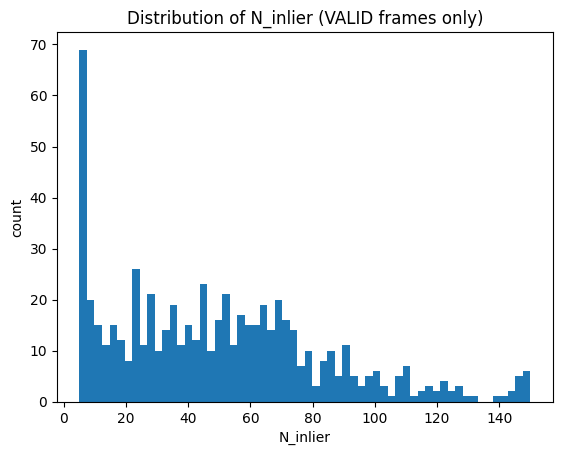

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_valid["N_inlier"].values, bins=60)
plt.title("Distribution of N_inlier (VALID frames only)")
plt.xlabel("N_inlier")
plt.ylabel("count")
plt.show()


Cell 11 — Save outputs for audit trail

In [17]:
OUT_DIR = Path(r"E:\0.TA_Teguh\Clustering GMM") / "_analysis_n_target"
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_per_subject_stats.to_csv(OUT_DIR / "per_subject_stats_valid.csv", index=False)
df_pressure.to_csv(OUT_DIR / "sampling_pressure_valid.csv", index=False)

print("Saved to:", OUT_DIR)


Saved to: E:\0.TA_Teguh\Clustering GMM\_analysis_n_target
